In [1]:
# this cell loads all files necessary for fitting a vanilla DDM (sometimes called the pure DDM)

using DriftDiffusionModels
using Plots
using Random
using Turing

In [ ]:
# this cell will simulate a DDM process so we have data we can fit later on, we will later fit to other data that is not simulated
B = 2.0       # bound height
v = 0.73      # drift rate
a₀ = 0.62     # initial starting point (as fraction of bound)
τ = 0.2       # non-decision time (s)

ddm_results = simulateDDM(DriftDiffusionModel(B, v, a₀, τ), 500, 1e-6) # simulate 500 trials with very small dt

500-element Vector{DDMResult}:
 DDMResult(0.5339929999945179, 1, 1)
 DDMResult(0.5515989999950242, -1, -1)
 DDMResult(0.38528699999660965, 1, 1)
 DDMResult(1.4319679999723816, 1, 1)
 DDMResult(0.49316399999372335, 1, 1)
 DDMResult(0.7656590000011796, -1, -1)
 DDMResult(0.371893999996968, 1, 1)
 DDMResult(0.6827859999987965, 1, 1)
 DDMResult(1.486966999967857, 1, 1)
 DDMResult(2.164133999948594, -1, -1)
 ⋮
 DDMResult(1.1730219999936842, -1, -1)
 DDMResult(0.6302159999972848, -1, -1)
 DDMResult(0.3720659999969634, 1, -1)
 DDMResult(0.4260919999955179, 1, 1)
 DDMResult(0.3927199999964108, 1, -1)
 DDMResult(0.41606999999578603, 1, 1)
 DDMResult(0.47484199999421356, 1, 1)
 DDMResult(0.657556999998071, -1, 1)
 DDMResult(0.626953999997191, 1, 1)

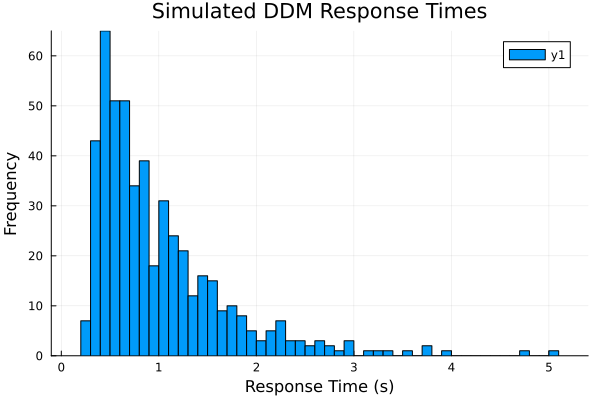

In [ ]:
# quickly plot the results so confirm it looks like a DDM!
rts = [res.rt for res in ddm_results]
histogram(rts, bins=50, title="Simulated DDM Response Times", xlabel="Response Time (s)", ylabel="Frequency")

In [13]:
# we can fit the model as follows
ddm = DriftDiffusionModel(;τ=0.05) #
fit!(ddm, ddm_results) 

println("Fitted DDM parameters:" )
println("Boundary Height: ", ddm.B)
println("Drift Rate: ", ddm.v)
println("Initial Starting Point: ", ddm.a₀)
println("Non-decision time: ", ddm.τ)

Fitted DDM parameters:
Boundary Height: 1.979854045238327
Drift Rate: 0.679712506327059
Initial Starting Point: 0.6406642668924791
Non-decision time: 0.21160372317186485


In [17]:
# now we can look at what if we have data from an experment, we can load it and fit the DDM to it
# assume you have some data like follows

rts = [0.45, 0.52, 0.39, 0.61, 0.48, 0.55, 0.50, 0.47, 0.60, 0.53] # response times in seconds
choices = [1, -1, 1, 1, -1, 1, -1, -1, 1, -1] # choices made (1 for right, -1 for left)
stimuli = [1, 1, -1, 1, -1, 1, -1, -1, 1, -1] # stimuli presented (1 for right, -1 for left)

# convert to DDMResult format
exp_results = [DDMResult(rt, choice, stim) for (rt, choice, stim) in zip(rts, choices, stimuli)]

# fit the DDM to "experimental data"
new_ddm = DriftDiffusionModel(;τ=0.1)

fit!(new_ddm, exp_results)
println("Fitted DDM parameters to experimental data:" )
println("Boundary Height: ", new_ddm.B)
println("Drift Rate: ", new_ddm.v)
println("Initial Starting Point: ", new_ddm.a₀)
println("Non-decision time: ", new_ddm.τ)

Fitted DDM parameters to experimental data:
Boundary Height: 0.8166938490882452
Drift Rate: 1.775723976857968
Initial Starting Point: 0.6081246537290286
Non-decision time: 0.37202351313758897
